In [94]:
# Import some libraries, in case you haven't yet imported them
import matplotlib.pyplot as plt
import numpy as np

def plotGauss(mean_0,mean_1,sd_0,sd_1,rho,vminmax=None,file=None,title=None):
    
    # size of grid
    N = 1000
    # generate grid (NB -1 to 1 here)
    coords = 2. * (np.arange(N+1)/float(N) - 0.5)
    x0, x1 = np.meshgrid(coords,coords)
    x = np.array([x0, x1])
    dx = np.array([x0[0,1] - x0[0,0], x1[1,0] - x1[0,0]])
    grid = dx[0] * dx[1]

    # set B
    b01 = b10 = rho * sd_0 * sd_1
    b00 = sd_0**2
    b11 = sd_1**2
    B = np.matrix([[b00,b01],[b10,b11]])
    # set xb: the mean
    xb = np.array([mean_0,mean_1])

    xxb = np.zeros_like(x)
    for i in range(xb.shape[0]): xxb[i,...] = xb[i]
    e = x - xxb

    n = np.shape(B)[0]
    # inverse of B
    BI = B.I
    # scaling term
    scale_1 = (2.*np.pi)**(n/2) * np.sqrt(np.linalg.det(B))
    gauss = np.exp(-0.5 * ((e[0,...] * BI[0,0] + e[1,...] * BI[0,1])* e[0,...]     \
                          + (e[0,...] * BI[1,0] + e[1,...] * BI[1,1])* e[1,...])) \
                          / scale_1

    # check integral
    print ('integral of Gaussian:',gauss.sum() * grid)

    # plot
    plt.clf()
    if title:
        plt.title(title)
    #if len(list(vminmax)):
    #    plt.imshow(gauss,origin='lower',interpolation='nearest', \
    #                    vmin=vminmax[0],vmax=vminmax[1],\
    #                    extent=[x0.min(),x0.max(),x1.min(),x1.max()])
    #else:
    plt.imshow(gauss,origin='lower',interpolation='nearest', \
                       extent=[x0.min(),x0.max(),x1.min(),x1.max()])
    plt.colorbar()
    if file == None:
        plt.show()
    else:
        plt.savefig(file)

integral of Gaussian: 0.990064099757
0.0110022559257


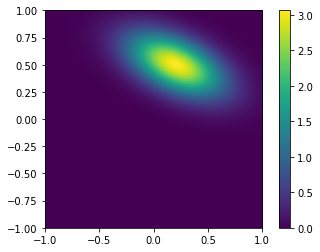

In [73]:
mean_0 = 0.2
mean_1 = 0.5
sd_0 = 0.3 #X0的标准差
sd_1 = 0.2 #X1的标准差
rho = -0.5 #X0和X1的相关系数
plotGauss(mean_0,mean_1,sd_0,sd_1,rho)

In [88]:
import numpy as np

mean_0 = 0.2
mean_1 = 0.5
sd_0 = 0.3
sd_1 = 0.2
# case 1: with correlation
rho = -0.5

test = [-0.3,0.2]
dx0 = test[0] - mean_0
dx1 = test[1] - mean_1
B00 = sd_0**2
B11 = sd_1**2
B01 = sd_0 * sd_1 * rho
#Z2 = (dx0*B00+dx1*B01)*dx0 + (dx0*B01+dx1*B11)*dx1 #该式错误，B矩阵没有转置
dx = np.matrix([[dx0],[dx1]])
B = np.matrix([[B00,B01],[B01,B11]])
Z2 = dx.T*B.I*dx #1*2,2*2,2*1
#detB = B00*B11 - B01**2 #可改为更通用的
detB = np.linalg.det(B)
scale = (2.*np.pi) * np.sqrt(detB)
p0 = (1./scale) * np.exp(-0.5 * Z2)
print ('p0: rho = -0.5: p(0,0) =',p0)

# case 2: without correlation
rho = -0.0

test = [-0.3,0.2]
dx0 = test[0] - mean_0
dx1 = test[1] - mean_1
B00 = sd_0**2
B11 = sd_1**2
B01 = sd_0 * sd_1 * rho
#Z2 = (dx0*B00+dx1*B01)*dx0 + (dx0*B01+dx1*B11)*dx1 #该式错误，B矩阵没有转置
dx = np.matrix([[dx0],[dx1]])
B = np.matrix([[B00,B01],[B01,B11]])
Z2 = dx.T*B.I*dx #1*2,2*2,2*1
detB = B00*B11 - B01**2
scale = (2.*np.pi) * np.sqrt(detB)
p1 = (1./scale) * np.exp(-0.5 * Z2)
print ('p1: rho =  0.0: p(0,0) =',p1)

p0: rho = -0.5: p(0,0) = [[ 0.02025925]]
p1: rho =  0.0: p(0,0) = [[ 0.214734]]


# 一个简单的同化例子

In [91]:
import numpy as np
import scipy.optimize

# prior
xb = np.array([0.1,0.5])
B  = np.matrix([[0.2**2,0.5*0.2*0.3],[0.5*0.2*0.3,0.3**2]])

# a direct observation: sd = 0.1
xr = np.array([0.15,0.4])
R  = np.matrix([[0.1**2,0.0],[0.0,0.1**2]])

BI = B.I
RI = R.I

# starting guess
x = np.array([0.,0.])

def cost(x,xb,BI,xr,RI):
    '''
    Return J and J' at x
    '''
    Jb = np.dot(np.array(0.5*(xb-x) * BI),(xb-x))[0]
    Jr = np.dot(np.array(0.5*(xr-x) * RI),(xr-x))[0]
    JbPrime = -(xb-x)*BI
    JrPrime = -(xr-x)*RI
    return Jr+Jb,np.array(JrPrime+JbPrime)[0]

def uncertainty(x,xb,BI,xr,RI):
    # inverse of Hessian
    return (BI + RI).I

retval = scipy.optimize.fmin_l_bfgs_b(cost,x,args=(xb,BI,xr,RI))

# x new
x = retval[0]
# uncertainty
Cpost = uncertainty(x,xb,BI,xr,RI)

# print prior
psigma0 = np.sqrt(B[0,0])
psigma1 = np.sqrt(B[1,1])
prho12  = B[0,1]/(psigma0*psigma1)
print ('prior:     x0,x1      :',xb[0],xb[1])
print ('prior:     sd0,sd1,rho:',psigma0,psigma1,prho12)

# print observation
rsigma0 = np.sqrt(R[0,0])
rsigma1 = np.sqrt(R[1,1])
rrho12  = R[0,1]/(rsigma0*rsigma1)
print ('observation: x0,x1      :',xr[0],xr[1])
print ('observation: sd0,sd1,rho:',rsigma0,rsigma1,rrho12)

sigma0 = np.sqrt(Cpost[0,0])
sigma1 = np.sqrt(Cpost[1,1])
rho12  = Cpost[0,1]/(sigma0*sigma1)
print ('posterior: x0,x1      :',x[0],x[1])
print ('posterior: sd0,sd1,rho:',sigma0,sigma1,rho12)

prior:     x0,x1      : 0.1 0.5
prior:     sd0,sd1,rho: 0.2 0.3 0.5
observation: x0,x1      : 0.15 0.4
observation: sd0,sd1,rho: 0.1 0.1 0.0
posterior: x0,x1      : 0.130487804878 0.415853658537
posterior: sd0,sd1,rho: 0.0869538705852 0.0937042571332 0.0898026510134


integral of Gaussian: 0.952539606871


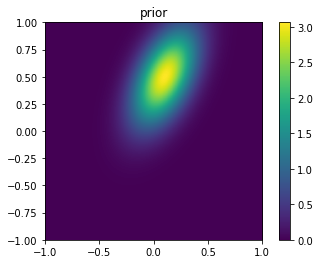

In [95]:
plotGauss(xb[0],xb[1],psigma0,psigma1,prho12,\
          title='prior')

integral of Gaussian: 0.999999999073


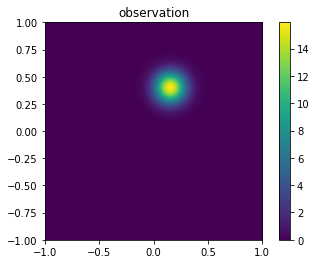

In [97]:
plotGauss(xr[0],xr[1],rsigma0,rsigma1,rrho12,\
          title='observation')

integral of Gaussian: 0.999999999788


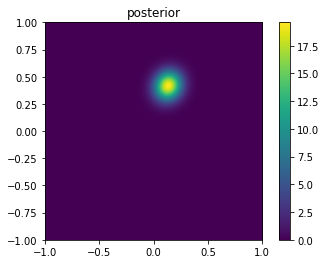

In [98]:
plotGauss(x[0],x[1],sigma0,sigma1,rho12,\
          title='posterior')